### Pediatric Sepsis: In-hospital Mortality Prediction

In [2278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

# Random Forest Model fitting
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



### Importing the dataset

In [2280]:
sepsis_df = pd.read_csv("SyntheticData_Training.csv") 
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
sepsis_df.head()

,studyid_adm,agecalc_adm,height_cm_adm,weight_kg_adm,muac_mm_adm,hr_bpm_adm,rr_brpm_app_adm,sysbp_mmhg_adm,diasbp_mmhg_adm,temp_c_adm,spo2site1_pc_oxi_adm,spo2site2_pc_oxi_adm,spo2other_adm,momage_adm,momagefirstpreg_adm,householdsize_adm,alivechildren_adm,deadchildren_adm,hematocrit_gpdl_adm,lactate_mmolpl_adm,lactate2_mmolpl_adm,glucose_mmolpl_adm,sqi1_perc_oxi_adm,sqi2_perc_oxi_adm,sex_adm,spo2onoxy_adm,oxygenavail_adm,respdistress_adm,caprefill_adm,bcseye_adm,bcsmotor_adm,bcsverbal_adm,admitabx_adm___1,admitabx_adm___2,admitabx_adm___3,admitabx_adm___4,admitabx_adm___5,admitabx_adm___6,admitabx_adm___7,admitabx_adm___8,admitabx_adm___9,admitabx_adm___10,admitabx_adm___11,admitabx_adm___12,admitabx_adm___13,admitabx_adm___14,admitabx_adm___15,admitabx_adm___16,admitabx_adm___17,admitabx_adm___18,admitabx_adm___19,admitabx_adm___20,admitabx_adm___21,bcgscar_adm,vaccmeasles_adm,vaccmeaslessource_adm,vaccpneumoc_adm,vaccpneumocsource_adm,vaccdpt_adm,vaccdptsource_adm,priorweekabx_adm,priorweekantimal_adm,symptoms_adm___1,symptoms_adm___2,symptoms_adm___3,symptoms_adm___4,symptoms_adm___5,symptoms_adm___6,symptoms_adm___7,symptoms_adm___8,symptoms_adm___9,symptoms_adm___10,symptoms_adm___11,symptoms_adm___12,symptoms_adm___13,symptoms_adm___14,symptoms_adm___15,symptoms_adm___16,symptoms_adm___18,comorbidity_adm___1,comorbidity_adm___2,comorbidity_adm___3,comorbidity_adm___4,comorbidity_adm___5,comorbidity_adm___6,comorbidity_adm___7,comorbidity_adm___8,comorbidity_adm___9,comorbidity_adm___10,comorbidity_adm___11,comorbidity_adm___12,priorhosp_adm,prioryearwheeze_adm,prioryearcough_adm,diarrheaoften_adm,tbcontact_adm,feedingstatus_adm,exclbreastfed_adm,nonexclbreastfed_adm,totalbreastfed_adm,deliveryloc_adm,birthattend_adm,duedateknown_adm,birthdetail_adm___1,birthdetail_adm___2,birthdetail_adm___3,birthdetail_adm___4,birthdetail_adm___5,birthdetail_adm___6,travelmethod_adm,traveldist_adm,badhealthduration_adm,caregiverage_adm,caregivermarried_adm,momalive_adm,momageknown_adm,momagefirstpregknown_adm,momedu_adm,momhiv_adm,watersource_adm,waterpure_adm,cookfuel_adm___1,cookfuel_adm___2,cookfuel_adm___3,cookfuel_adm___4,cookfuel_adm___5,cookfuel_adm___6,cookfuel_adm___7,cookloc_adm,lightfuel_adm,tobacco_adm,bednet_adm,hctpretransfusion_adm,hivstatus_adm,malariastatuspos_adm,lengthadm,caregiver_adm_new,inhospital_mortality
0,1,16.8,79.8,11.6,150.0,130.0,23.0,92.0,54.0,36.3,99.0,99.0,NaN,27.0,23.0,6.0,1.0,0.0,38.0,2.2,NaN,4.8,98.0,97.0,Female,No,Oxygen available and not being used,No,No,Watches or follows,Localizes painful stimulus,"Cries appropriately with pain, or, if verbal, ...",Unchecked,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Yes,Yes,Self report,3 doses,Self report,3 doses,Self report,Yes,No,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Never,No,No,No,Yes,Feeding poorly,6 months,NaN,>12 months,Health centre,Nurse / midwife,Yes,Unchecked,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Taxi/special hire,30 minutes - 1 hour,In good health prior to this illness,> 18 years old,Married monogamous,Yes,Yes,Yes,Post secondary (including post S4 technical sc...,Negative,Municipal water,Yes,Checked,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,In a separate building/building space used as ...,Electric bulbs (national grid),Never,Always,Yes,HIV negative,No,2,Mother,0
1,2,46.1,93.0,13.6,151.0,115.0,35.0,72.0,42.0,36.8,92.0,91.0,NaN,30.0,25.0,4.0,2.0,0.0,42.0,2.7,NaN,7.2,99.0,85.0,Female,No,Oxygen available and not being used,No,No,Watches or follows,Localizes painful stimulus,"Cries appropriately with pain, or, if verbal, ...",Checked,Un

### Looking into the data structure

In [2282]:
sepsis_df.info()
pd.set_option('display.max_rows', None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Columns: 138 entries, studyid_adm to inhospital_mortality
dtypes: float64(23), int64(3), object(112)
memory usage: 2.8+ MB


In [2283]:
sepsis_df.duplicated().sum()

0

### Understanding the Column Characteristics

In [2285]:
#Create a summary DataFrame of column characteristics

column_summary= pd.DataFrame({'Column': sepsis_df.columns, 
                              'Data Type': sepsis_df.dtypes.values,
                              'Missing Values': sepsis_df.isnull().sum().values,
                              'Missing %': (sepsis_df.isnull().mean() * 100).values,
                              'Unique Values': sepsis_df.nunique().values})



# Display all rows in the column summary
pd.set_option('display.max_rows', None)

# Print
print(column_summary)

                       Column Data Type  Missing Values  Missing %  \
0                 studyid_adm     int64               0   0.000000   
1                 agecalc_adm   float64               0   0.000000   
2               height_cm_adm   float64              14   0.521221   
3               weight_kg_adm   float64               9   0.335071   
4                 muac_mm_adm   float64              13   0.483991   
5                  hr_bpm_adm   float64               1   0.037230   
6             rr_brpm_app_adm   float64               5   0.186150   
7              sysbp_mmhg_adm   float64               2   0.074460   
8             diasbp_mmhg_adm   float64               1   0.037230   
9                  temp_c_adm   float64               1   0.037230   
10       spo2site1_pc_oxi_adm   float64               4   0.148920   
11       spo2site2_pc_oxi_adm   float64             205   7.632167   
12              spo2other_adm   float64            2505  93.261355   
13                 m

## Data Cleaning

### Dropping columns

#### 1. Dropping the Intervention Columns

Dropped intervention columns: These variables represent treatments that, while powerful predictors, are excluded due to their post-admission nature. The model, however, relies on data available at the time of admission.

In [2289]:
# Removing leading/trailing whitespace
sepsis_df.columns = sepsis_df.columns.str.strip()

# Define the intervention columns we want to drop
intervention_cols = [f"admitabx_adm___{i}" for i in range(1, 22)]

# Dropping them
sepsis_df.drop(columns=intervention_cols, inplace=True, errors='ignore')

# Confirming
print("Remaining columns:", sepsis_df.shape[1])
print("Dropped intervention columns:", intervention_cols)


Remaining columns: 117
Dropped intervention columns: ['admitabx_adm___1', 'admitabx_adm___2', 'admitabx_adm___3', 'admitabx_adm___4', 'admitabx_adm___5', 'admitabx_adm___6', 'admitabx_adm___7', 'admitabx_adm___8', 'admitabx_adm___9', 'admitabx_adm___10', 'admitabx_adm___11', 'admitabx_adm___12', 'admitabx_adm___13', 'admitabx_adm___14', 'admitabx_adm___15', 'admitabx_adm___16', 'admitabx_adm___17', 'admitabx_adm___18', 'admitabx_adm___19', 'admitabx_adm___20', 'admitabx_adm___21']


#### 2. Dropping other additional Columns

In [2291]:
# Dropping unnecessary columns
sepsis_df = sepsis_df.drop(["spo2other_adm","lactate2_mmolpl_adm","nonexclbreastfed_adm","vaccmeaslessource_adm"], axis=1)

#### Justification for dropping
___
* **"spo2other\_adm" dropped:** Represents oxygen saturation with another device (redundant), and has 93.3% missing values.
* **"lactate2\_mmolpl\_adm" dropped:** A similar measurement is available, and it has 82.54% missing values.
* **"nonexclbreastfed\_adm" dropped:** Represents non-exclusive breastfeeding details, with 96.91% missing values.
* **"vaccmeaslessource\_adm" dropped:** Represents the source of information regarding measles vaccination (found to be less important), with 35.22% missing values.
___

### Handling Missing Values

#### 1. Numerical Variables with Missing Values

*Clean numeric-columns*

In [2296]:
# Get columns that have at least one missing value
cols_with_missing = sepsis_df.columns[sepsis_df.isnull().any()].tolist()

# Create a new DataFrame with only those columns
df_missing_subset = sepsis_df[cols_with_missing]

# Select numeric columns only
numeric_cols = df_missing_subset.select_dtypes(include='number')

# Calculate skewness for each numeric column
skewness = numeric_cols.skew()

# Filter columns where skewness is between -0.5 and +0.5
symmetric_cols = skewness[(skewness > -0.5) & (skewness < 0.5)].index.tolist()

print("Columns with fairly symmetric distributions:", symmetric_cols)

Columns with fairly symmetric distributions: ['muac_mm_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm', 'hematocrit_gpdl_adm']


___
Columns with fairly symmetric distributions (skewness between -0.5 and 0.5) were identified using the `.skew()` function and separated for imputation using the **mean**. For columns with more skewed distributions (skewness < -0.5 or > 0.5), the **median** will be used instead, as it's more robust to outliers.
___

#### Imputing the columns with fairly symmetric distributions using mean

In [2299]:
sepsis_df[['sysbp_mmhg_adm', 'diasbp_mmhg_adm']] = sepsis_df[['sysbp_mmhg_adm', 'diasbp_mmhg_adm']].fillna(sepsis_df[['sysbp_mmhg_adm', 'diasbp_mmhg_adm']].mean())

#### Imputing 'height_cm_adm' column

In [2301]:
# Show relevant info where height is missing
sepsis_df.loc[sepsis_df['height_cm_adm'].isnull(), ['weight_kg_adm', 'agecalc_adm', 'sex_adm']]

,weight_kg_adm,agecalc_adm,sex_adm
370,13.0,23.3,Male
430,NaN,29.0,Male
858,NaN,30.1,Female
928,NaN,26.9,Male
956,5.8,22.0,Male
1025,NaN,15.5,Male
1178,13.0,52.2,Female
1360,NaN,21.2,Female
1785,9.0,22.5,Male
1855,9.0,10.6,Male


* To handle missing values in the height_cm_adm column, the approach involves imputing the missing heights using the WHO median height-for-age data. The patient's age in months is rounded to the nearest whole number to align with the WHO data, which includes median height values for different age months. The missing values in the height_cm_adm column are then filled with the corresponding median height from the WHO dataset based on the patient's rounded age.
  
* This method ensures that the imputed heights are age-appropriate and based on established growth standards, improving the overall quality of the dataset for analysis.

##### *For Female*

In [2304]:
# Loading the WHO dataset for girls
who_girls = pd.read_csv("girls_length_height_for_age.csv")

In [2305]:
# Round age to match WHO months
sepsis_df['age_months_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Prepare WHO data
who_clean = who_girls[['Months', 'Median']].rename(columns={
    'Months': 'age_months_rounded',
    'Median': 'who_median_height'
})

# Merge on the rounded age
sepsis_df = sepsis_df.merge(
    who_clean,
    on='age_months_rounded',
    how='left'
)

* The patient's age in months is rounded to the nearest whole number to align with the WHO data. The WHO median height-for-age data for girls is then cleaned and merged with the sepsis dataset based on the rounded age.

* This ensures that each patient is matched with the appropriate WHO median height based on their age.

In [2307]:
# Identify missing heights for female patients
girls_mask = (sepsis_df['sex_adm'] == 'Female') & (sepsis_df['height_cm_adm'].isna())

# Impute with WHO median height based on rounded age
sepsis_df.loc[girls_mask, 'height_cm_adm'] = sepsis_df.loc[girls_mask, 'who_median_height']

* This code identifies missing height values for female patients by creating a mask where the sex_adm is 'Female' and height_cm_adm is null.

* Then, for these patients, the missing height values are imputed using the corresponding WHO median height based on the patient's rounded age in months.

##### *For Male*

In [2310]:
# Loading the WHO dataset for boys
who_boys = pd.read_csv("boys_length_height_for_age.csv")

In [2311]:
# Round age to match WHO months
sepsis_df['age_months_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Prepare WHO data
who_clean_boys = who_boys[['Months', 'Median']].rename(columns={
    'Months': 'age_months_rounded',
    'Median': 'who_median_height_boys'
})

# Merge on the rounded age
sepsis_df = sepsis_df.merge(
    who_clean_boys,
    on='age_months_rounded',
    how='left'
)

* In this process, the age calculation of the children in the sepsis dataset is rounded to the nearest whole month using the agecalc_adm column. This rounded age is stored in a new column age_months_rounded.

* Next, the WHO data for boys is prepared by extracting the relevant columns (Months and Median) from the who_boys dataset and renaming them to age_months_rounded and who_median_height_boys, ensuring consistency with the sepsis dataset.

* Finally, the two datasets are merged based on the rounded age (age_months_rounded), allowing the sepsis dataset to be enriched with the WHO median height for boys based on the rounded age, creating a column called who_median_height_boys in the sepsis_df.

In [2313]:
# Identify missing heights for male patients
boys_mask = (sepsis_df['sex_adm'] == 'Male') & (sepsis_df['height_cm_adm'].isna())

# Impute with WHO median height based on rounded age for boys
sepsis_df.loc[boys_mask, 'height_cm_adm'] = sepsis_df.loc[boys_mask, 'who_median_height_boys']

# Check for missing values again
sepsis_df['height_cm_adm'].isna().sum()

0

* This process identifies missing height values (height_cm_adm) for male patients in the dataset.
* For those missing values, the heights are imputed using the WHO median height for boys based on the rounded age.
* After the imputation, the number of remaining missing height values is checked to confirm the success of the imputation of the **height_cm_adm** column.

#### Imputing 'weight_kg_adm' column

* To impute missing weight values in the dataset, we used a reference-based approach leveraging the WHO weight-for-age data. By rounding the age of each patient to the nearest integer, we matched it with the corresponding median weight for boys and girls from the WHO dataset. This allowed us to impute missing weights based on the median value for the given age and sex, ensuring a more accurate and contextually relevant imputation method.

In [2317]:
# Load WHO data
boys_wfa = pd.read_csv("boys_weight_for_age.csv")  
girls_wfa = pd.read_csv("girls_weight_for_age.csv") 

In [2318]:
# Round the age to the nearest integer
sepsis_df['agecalc_adm_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Function to impute missing weight values
def impute_weight(row):
    if pd.isna(row['weight_kg_adm']):
        if row['sex_adm'] == 'Male':
            # Get the median weight for boys based on the agecalc_adm
            ref = boys_wfa[boys_wfa['Months'] == row['agecalc_adm_rounded']]['Median'].values[0]
        else:
            # Get the median weight for girls based on the agecalc_adm
            ref = girls_wfa[girls_wfa['Months'] == row['agecalc_adm_rounded']]['Median'].values[0]
        return ref
    return row['weight_kg_adm']

# Apply the imputation to the dataset
sepsis_df['weight_kg_adm'] = sepsis_df.apply(impute_weight, axis=1)

# Check for missing values again
sepsis_df['weight_kg_adm'].isna().sum()

0

* The process of imputing missing values in the weight_kg_adm column begins by loading the WHO weight-for-age datasets for boys and girls. The age column (agecalc_adm) in the sepsis_df dataset is then rounded to the nearest integer to match the age format used in the WHO datasets. A custom function, impute_weight, is created to fill in missing values.
* For each row with a missing weight, the function checks the sex of the patient and retrieves the corresponding median weight from the appropriate WHO dataset (boys or girls) based on the rounded age. This median value is then used to impute the missing weight.
* The function is applied to the entire dataset, and the weight_kg_adm column is updated accordingly. Finally, a check is performed to confirm that there are no remaining missing values in the weight column, ensuring successful imputation.

#### Imputing MUAC based on age

In [2321]:
# Loading the WHO dataset for girls
who_girls = pd.read_csv("./acfa-girls-3-5-zscores.csv")

# Round age to match WHO months
sepsis_df['age_months_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Prepare WHO data
who_clean = who_girls[['Month', 'SD0']].rename(columns={
    'Month': 'age_months_rounded',
    'SD0': 'who_median_muac'
})

# Merge on the rounded age
sepsis_df = sepsis_df.merge(
    who_clean,
    on='age_months_rounded',
    how='left',
    suffixes=('', '_who')  # Adding a suffix '_who' to differentiate the columns
)

# Identify missing muac for female patients
girls_mask = (sepsis_df['sex_adm'] == 'Female') & (sepsis_df['muac_mm_adm'].isna())

# Impute with WHO median muac based on rounded age
sepsis_df.loc[girls_mask, 'muac_mm_adm'] = sepsis_df.loc[girls_mask, 'who_median_muac']

# Loading the WHO dataset for boys
who_boys = pd.read_csv("./acfa-boys-3-5-zscores.csv")

# Round age to match WHO months
sepsis_df['age_months_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Prepare WHO data
who_clean_boys = who_boys[['Month', 'SD0']].rename(columns={
    'Month': 'age_months_rounded',
    'SD0': 'who_median_muac'
})

# Merge on the rounded age
sepsis_df = sepsis_df.merge(
    who_clean_boys,
    on='age_months_rounded',
    how='left',
    suffixes=('', '_who')  # Adding a suffix '_who' to differentiate the columns
)

# Identify missing heights for male patients
boys_mask = (sepsis_df['sex_adm'] == 'Male') & (sepsis_df['muac_mm_adm'].isna())

# Impute with WHO median height based on rounded age for boys
sepsis_df.loc[boys_mask, 'muac_mm_adm'] = sepsis_df.loc[boys_mask, 'who_median_muac']

# Check for missing values again
sepsis_df['muac_mm_adm'].isna().sum()

0

___
**"muac_mm_adm"** was imputed by grouping the data based on age_group, weight quintiles (weight_group), and sex_adm, then filling missing values with the mean MUAC within each subgroup.
___

#### Imputing 'hematocrit_gpdl_adm' column

In [2324]:
# Step 1: Define the age group bins
def assign_age_group(age_months):
    if age_months < 6:
        return '3-6 month'
    elif age_months < 12:
        return '6-1yr'
    elif age_months < 24:
        return '1-2yr'
    elif age_months < 36:
        return '2-3yr'
    elif age_months < 48:
        return '3-4yr'
    elif age_months < 60:
        return '4-5yr'
    elif age_months < 72:
        return '5-6yr'
    else:
        return 'older'

# Step 2: Create 'age_group' column
sepsis_df['age_group'] = sepsis_df['agecalc_adm'].apply(assign_age_group)

# Step 3: Group by age_group and sex_adm, then impute hematocrit
sepsis_df['hematocrit_gpdl_adm'] = sepsis_df.groupby(['age_group', 'sex_adm'])['hematocrit_gpdl_adm']\
    .transform(lambda x: x.fillna(x.mean()))
print(sepsis_df["hematocrit_gpdl_adm"].isnull().sum())

0


___
" hematocrit_gpdl_adm " was imputed using a logical, group-based approach. Since hematocrit levels vary by age and sex, first  patients were categorized into age groups and then grouped the data by both age_group and sex_adm.
Within each group, missing hematocrit values were filled using the mean of that group, ensuring the imputation respects biologically relevant differences.
___

#### Imputing 'lactate_mmolpl_adm' column

In [2327]:
# Create shock index
sepsis_df['shockindex_heart_rate_sbp_adm'] = sepsis_df['hr_bpm_adm'] / sepsis_df['sysbp_mmhg_adm']

# Create high-risk indicator based on SpO2 and shock index
sepsis_df['high_risk'] = ((sepsis_df['spo2site1_pc_oxi_adm'] < 90) | 
                          (sepsis_df['shockindex_heart_rate_sbp_adm'] > 1)).astype(int)

# Impute lactate using median within risk groups (only one transform needed)
sepsis_df['lactate_mmolpl_adm'] = sepsis_df.groupby('high_risk')['lactate_mmolpl_adm']\
                                           .transform(lambda x: x.fillna(x.median()))


___
"shockindex_heart_rate_sbp_adm" was created to aid imputation of missing values in the "lactate_mmolpl_adm" column. It was derived from "hr_bpm_adm" and "sysbp_mmhg_adm"  columns. 

* Created a `high_risk` flag for patients with SpO₂ < 90 or shock index > 1.
  These thresholds are clinically meaningful indicators of potential instability.
* Imputed missing `lactate_mmolpl_adm` values using the median within each risk group.
  This ensures imputation is done in a context-sensitive way, preserving group-level distribution patterns.
  
___

#### Imputing 'spo2site1_pc_oxi_adm' and 'spo2site1_pc_oxi_adm'

In [2330]:
# Use spo2site2 to fill missing values in spo2site1
sepsis_df['spo2site1_pc_oxi_adm'] = sepsis_df['spo2site1_pc_oxi_adm'].fillna(
    sepsis_df['spo2site2_pc_oxi_adm']
)

# Use spo2site1 to fill missing values in spo2site2
sepsis_df['spo2site2_pc_oxi_adm'] = sepsis_df['spo2site2_pc_oxi_adm'].fillna(
    sepsis_df['spo2site1_pc_oxi_adm']
)

In [2331]:
# Checking if we still have missing values
print(sepsis_df['spo2site1_pc_oxi_adm'].isnull().sum())
print(sepsis_df['spo2site2_pc_oxi_adm'].isnull().sum())

4
4


##### Imputing the remaining missing values in both coulumns

In [2333]:
# Create age group
sepsis_df['age_group2'] = sepsis_df['agecalc_adm'].apply(lambda x: '<1yr' if x < 1 else '≥1yr')

# Impute SpO2 site 1
sepsis_df['spo2site1_pc_oxi_adm'] = sepsis_df.groupby('age_group2')['spo2site1_pc_oxi_adm']\
                                             .transform(lambda x: x.fillna(x.median()))

# Impute SpO2 site 2
sepsis_df['spo2site2_pc_oxi_adm'] = sepsis_df.groupby('age_group2')['spo2site2_pc_oxi_adm']\
                                             .transform(lambda x: x.fillna(x.median()))

___
The columns **'spo2site1\_pc\_oxi\_adm'** and **'spo2site2\_pc\_oxi\_adm'** represent oxygen saturation levels (percentage of hemoglobin carrying oxygen) from two different body sites. Since both measure similar values, **cross imputation** was used to fill missing values. However, 4 missing values were observed, suggesting that 4 rows were missing data for both columns. To account for age-related physiological differences (e.g., respiratory rate, oxygen saturation, heart rate), an **age\_group2** variable was created to categorize patients as <1 year or ≥1 year. Missing SpO₂ values were then imputed using the median within each age group.
___

#### Imputing 'sqi1_perc_oxi_adm' and 'sqi2_perc_oxi_adm'

In [2336]:
# Use cross-SQI imputation
sepsis_df['sqi1_perc_oxi_adm'] = sepsis_df['sqi1_perc_oxi_adm'].fillna(sepsis_df['sqi2_perc_oxi_adm'])
sepsis_df['sqi2_perc_oxi_adm'] = sepsis_df['sqi2_perc_oxi_adm'].fillna(sepsis_df['sqi1_perc_oxi_adm'])

In [2337]:
# Checking if we still have missing values
print(sepsis_df['sqi1_perc_oxi_adm'].isnull().sum())
print(sepsis_df['sqi2_perc_oxi_adm'].isnull().sum())

126
126


In [2338]:
# Imputing the rest with median
sepsis_df['sqi1_perc_oxi_adm'] = sepsis_df['sqi1_perc_oxi_adm'].fillna(sepsis_df['sqi1_perc_oxi_adm'].median())
sepsis_df['sqi2_perc_oxi_adm'] = sepsis_df['sqi2_perc_oxi_adm'].fillna(sepsis_df['sqi2_perc_oxi_adm'].median())

___
The columns **'sqi1\_perc\_oxi\_adm'** and **'sqi2\_perc\_oxi\_adm'** represent the best and second-best SpO₂ signal quality index at admission. 
* **`sqi1_perc_oxi_adm`** = Highest quality SpO₂ signal among all measured sites at admission.
* **`sqi2_perc_oxi_adm`** = Second-best quality SpO₂ signal from a different site at admission.
Since they are related, **cross-imputation** was applied. However, 126 rows remained missing for both columns, so the remaining missing values were filled using the median.
___

#### **Imputing the columns that do not need logical imputing and have skewed distribution**

In [2341]:
# Select numerical columns with missing values
num_cols_with_na = sepsis_df.select_dtypes(include=np.number).columns[sepsis_df.select_dtypes(include=np.number).isna().any()]
# List of columns to exclude
exclude_cols = ['muac_mm_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm', 'hematocrit_gpdl_adm',
                'height_cm_adm', 'weight_kg_adm', 'lactate_mmolpl_adm', 'spo2site1_pc_oxi_adm',
                'spo2site2_pc_oxi_adm', 'sqi1_perc_oxi_adm', 'sqi2_perc_oxi_adm']
# Drop those columns from the list
filtered_num_cols = [col for col in num_cols_with_na if col not in exclude_cols]

# Impute the remaining numerical columns with median
sepsis_df[filtered_num_cols] = sepsis_df[filtered_num_cols].apply(lambda col: col.fillna(col.median()))

### 2. Categorical Variables with Missing Values

#### Imputing 'bcseye_adm' column

* This below code investigates whether missing values in the bcseye_adm variable (Blantyre Coma Scale – Eye Response) are associated with the availability of related coma scale components, specifically:
                        
                        - bcsmotor_adm – Motor Response
                        - bcsverbal_adm – Verbal Response

In [2345]:
# Identify rows where 'bcseye_adm' is missing
missing_eye = sepsis_df['bcseye_adm'].isna()

# Print the corresponding 'bcsmotor_adm' and 'bcsverbal_adm' values where 'bcseye_adm' is missing
print(sepsis_df[missing_eye][['bcsmotor_adm', 'bcsverbal_adm']])

                               bcsmotor_adm  \
1388  No response or inappropriate response   

                                          bcsverbal_adm  
1388  Cries appropriately with pain, or, if verbal, ...  


In [2346]:
# Verifying the exact patient record
patient_1388 = sepsis_df.loc[1388, ['bcseye_adm', 'bcsmotor_adm', 'bcsverbal_adm']]
print(patient_1388)

bcseye_adm                                                     NaN
bcsmotor_adm                 No response or inappropriate response
bcsverbal_adm    Cries appropriately with pain, or, if verbal, ...
Name: 1388, dtype: object


In [2347]:
# Impute missing as "NoFollow" (most severe neurological status)
sepsis_df['bcseye_adm'] = sepsis_df['bcseye_adm'].fillna('Fails to watch or follow')
print(sepsis_df["bcseye_adm"].isnull().sum())


0


* This output shows that even though bcseye_adm is missing for this patient (row 1388):
                        
                        - bcsmotor_adm is present but indicates very low motor responsiveness
                        - bcsverbal_adm is present and shows some verbal responsiveness

**Since bcsmotor_adm is very low and bcseye_adm is missing, it is reasonable to impute a worst-case value like "Fails to watch or follow" for bcseye_adm**

#### Imputing 'bcsverbal_adm' column

In [2350]:
# Identify rows where 'bcsverbal_adm' (verbal response) is missing
missing_verbal = sepsis_df['bcsverbal_adm'].isna()

# Display corresponding eye and motor responses for those rows
print(sepsis_df[missing_verbal][['bcseye_adm', 'bcsmotor_adm']])

              bcseye_adm                          bcsmotor_adm
507   Watches or follows  Withdraws limb from painful stimulus
1205  Watches or follows  Withdraws limb from painful stimulus


* This code identifies all records where the verbal response (bcsverbal_adm) is missing and displays the corresponding eye and motor response values. It helps assess whether there is a consistent pattern that could be used to logically impute the missing verbal scores.

In [2352]:
# Filter records with the same eye/motor scores to find the most frequent verbal response
subgroup_mask = (
    (sepsis_df['bcseye_adm'] == 'Watches or follows') & 
    (sepsis_df['bcsmotor_adm'] == 'Withdraws limb from painful stimulus')
)
mode_verbal = sepsis_df[subgroup_mask]['bcsverbal_adm'].mode()[0]  # Most common in this subgroup

# Apply to missing cases
sepsis_df.loc[[507, 1205], 'bcsverbal_adm'] = mode_verbal

* This code filters the dataset to records where both the eye and motor responses match the specified clinical patterns. It then identifies the most common (modal) verbal response within that subgroup. This modal value is then used to fill in the missing verbal response entries (rows 507 and 1205), ensuring the imputation is clinically consistent.

#### Imputing 'hivstatus_adm' column

In [2355]:
sepsis_df['hivstatus_adm'] = sepsis_df['hivstatus_adm'].fillna('NotTested')

* The column **'hivstatus\_adm'** was imputed with **'NotTested'** since it was challenging to reliably estimate the missing values using the same or related columns.

#### Imputing 'hctpretransfusion_adm' column

Text(0.5, 1.0, 'Boxplot of Hematocrit by Pre-Transfusion Status')

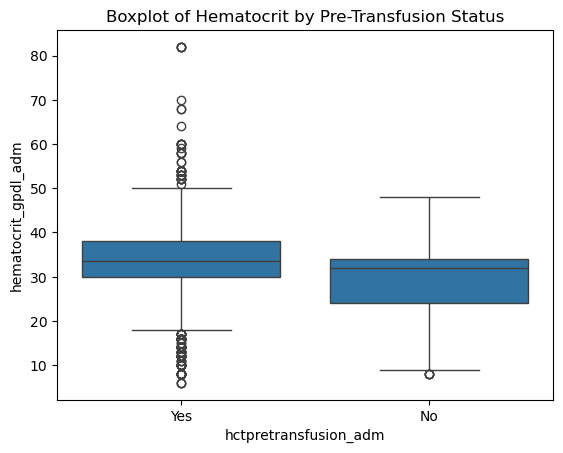

In [2358]:
sns.boxplot(sepsis_df,x="hctpretransfusion_adm",y="hematocrit_gpdl_adm")
plt.title("Boxplot of Hematocrit by Pre-Transfusion Status")

In [2359]:
# First, calculate mode (most frequent value)
mode_value = sepsis_df['hctpretransfusion_adm'].mode()[0]

# Define custom function
def impute_hctpretransfusion(row):
    if pd.isna(row['hctpretransfusion_adm']):
        if row['hematocrit_gpdl_adm'] < 10 or row['hematocrit_gpdl_adm'] > 50:
            return 'Yes'
        else:
            return mode_value
    else:
        return row['hctpretransfusion_adm']

# Apply the function to fill missing values
sepsis_df['hctpretransfusion_adm'] = sepsis_df.apply(impute_hctpretransfusion,axis=1)

* **"hctpretransfusion\_adm"** was imputed using a **distribution-based method** guided by a box plot analysis. Since the upper whisker for “No” responses was around 50 and the lower whisker around 10 (based on hematocrit values), missing entries with hematocrit values outside this range were classified as **"Yes"**. The remaining missing values were filled using the **mode**.

#### Imputing columns that do not need Logical Imputing with Mode

In [2362]:
# List of categorical columns to exclude from imputation
exclude_cat_cols = ['bcseye_adm', 'bcsverbal_adm', 'hivstatus_adm', 'hctpretransfusion_adm']

# Select categorical columns with missing values
cat_cols_with_na = [col for col in sepsis_df.select_dtypes(include='object').columns 
                    if sepsis_df[col].isna().sum() > 0]

# Drop excluded columns
filtered_cat_cols = [col for col in cat_cols_with_na if col not in exclude_cat_cols]

# Impute remaining categorical columns with mode
for col in filtered_cat_cols:
    mode_val = sepsis_df[col].mode(dropna=True)[0]
    sepsis_df[col] = sepsis_df[col].fillna(mode_val)

### Checking for Missing Values after Imputation is done

In [2364]:
sepsis_df.isnull().sum()

studyid_adm                      0
agecalc_adm                      0
height_cm_adm                    0
weight_kg_adm                    0
muac_mm_adm                      0
hr_bpm_adm                       0
rr_brpm_app_adm                  0
sysbp_mmhg_adm                   0
diasbp_mmhg_adm                  0
temp_c_adm                       0
spo2site1_pc_oxi_adm             0
spo2site2_pc_oxi_adm             0
momage_adm                       0
momagefirstpreg_adm              0
householdsize_adm                0
alivechildren_adm                0
deadchildren_adm                 0
hematocrit_gpdl_adm              0
lactate_mmolpl_adm               0
glucose_mmolpl_adm               0
sqi1_perc_oxi_adm                0
sqi2_perc_oxi_adm                0
sex_adm                          0
spo2onoxy_adm                    0
oxygenavail_adm                  0
respdistress_adm                 0
caprefill_adm                    0
bcseye_adm                       0
bcsmotor_adm        

* Observation : All columns do not contain missing value.

### Now we drop the columns that were added during the cleaning process

In [2367]:
sepsis_df.columns.get_loc('inhospital_mortality')
sepsis_df = sepsis_df.drop(sepsis_df.columns[113:], axis=1)

#### *Saving the Cleaned DataSet in a New CSV file*

In [2369]:
# sepsis_df.to_csv("sepsis_cleaned.csv", index=False)

### Hypothesis Testing

To better understand which features are potentially associated with **in-hospital mortality**, we performed hypothesis testing for both **categorical** and **continuous** variables. This helps us identify variables that exhibit statistically significant differences between patients who **survived (0)** and those who **died (1)** during hospitalization.

---

#### Categorical Features – Chi-Square Test of Independence

This test evaluates whether there is a significant association between each categorical variable and the target outcome.

- **Null Hypothesis (H₀):** There is no association between the categorical feature and in-hospital mortality.  
- **Alternative Hypothesis (H₁):** There is a significant association between the categorical feature and in-hospital mortality.

---

#### Continuous Features – Mann-Whitney U Test

This non-parametric test is used to compare the distributions of two independent groups. It is preferred here due to the likely non-normal distribution of clinical measurements.

- **Null Hypothesis (H₀):** The distributions of the continuous variable are equal for survivors and non-survivors.  
- **Alternative Hypothesis (H₁):** The distributions of the continuous variable differ between survivors and non-survivors.

---

By identifying features with **low p-values** (typically **p < 0.01**), we can prioritize them in downstream modeling, as they may hold predictive value for mortality outcomes.



In [2371]:
# Separate the target
target = 'inhospital_mortality'

# 1. Identify categorical and continuous features (excluding target)
categorical_features = sepsis_df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
continuous_features = sepsis_df.select_dtypes(include=['int64', 'float64']).drop(columns=[target]).columns.tolist()

# 2. Chi-square test for categorical features
print("\n--- Chi-Square Test Results ---")
for col in categorical_features:
    contingency_table = pd.crosstab(sepsis_df[col], sepsis_df[target])
    if contingency_table.shape[0] > 1:
        chi2, p, dof, _ = stats.chi2_contingency(contingency_table)
        print(f"{col}: p-value = {p:.4f}")

# 3. Mann-Whitney U Test for continuous features (non-parametric)
print("\n--- Mann-Whitney U Test Results ---")
for col in continuous_features:
    survived = sepsis_df[sepsis_df[target] == 0][col]
    died = sepsis_df[sepsis_df[target] == 1][col]
    u_stat, p_value = stats.mannwhitneyu(survived, died, alternative='two-sided')
    print(f"{col}: p-value = {p_value:.4f}")



--- Chi-Square Test Results ---
sex_adm: p-value = 0.5463
spo2onoxy_adm: p-value = 0.0000
oxygenavail_adm: p-value = 0.0000
respdistress_adm: p-value = 0.0002
caprefill_adm: p-value = 0.0064
bcseye_adm: p-value = 0.0000
bcsmotor_adm: p-value = 0.0000
bcsverbal_adm: p-value = 0.0000
bcgscar_adm: p-value = 0.0002
vaccmeasles_adm: p-value = 0.8093
vaccpneumoc_adm: p-value = 0.0492
vaccpneumocsource_adm: p-value = 0.9819
vaccdpt_adm: p-value = 0.0303
vaccdptsource_adm: p-value = 0.7855
priorweekabx_adm: p-value = 0.9838
priorweekantimal_adm: p-value = 0.7438
symptoms_adm___1: p-value = 0.8541
symptoms_adm___2: p-value = 0.0919
symptoms_adm___3: p-value = 0.0365
symptoms_adm___4: p-value = 0.1887
symptoms_adm___5: p-value = 0.9805
symptoms_adm___6: p-value = 0.7932
symptoms_adm___7: p-value = 0.3056
symptoms_adm___8: p-value = 0.6099
symptoms_adm___9: p-value = 0.6950
symptoms_adm___10: p-value = 0.7872
symptoms_adm___11: p-value = 0.7196
symptoms_adm___12: p-value = 0.5825
symptoms_adm___

#### Identifying Significant Columns based on p values

In [2373]:
# 1. Separate categorical and continuous features
target = 'inhospital_mortality'
categorical_features = sepsis_df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
continuous_features = sepsis_df.select_dtypes(include=['int64', 'float64']).drop(columns=[target]).columns.tolist()

# 2. Chi-Square test for categorical features
significant_cat = []
for col in categorical_features:
    contingency = pd.crosstab(sepsis_df[col], sepsis_df[target])
    if contingency.shape[0] > 1:
        chi2, p, _, _ = stats.chi2_contingency(contingency)
        if p < 0.01:
            significant_cat.append(col)

# 3. Mann-Whitney U Test for continuous features
significant_cont = []
for col in continuous_features:
    group0 = sepsis_df[sepsis_df[target] == 0][col]
    group1 = sepsis_df[sepsis_df[target] == 1][col]
    try:
        u_stat, p_value = stats.mannwhitneyu(group0, group1, alternative='two-sided')
        if p_value < 0.01:
            significant_cont.append(col)
    except:
        pass  # Skip if error due to too many NaNs or invalid inputs

# 4. Combine and review
significant_features = significant_cat + significant_cont
print(f"Total insignificant features (p < 0.01): {len(significant_features)}")
print(significant_features)

Total insignificant features (p < 0.01): 20
['spo2onoxy_adm', 'oxygenavail_adm', 'respdistress_adm', 'caprefill_adm', 'bcseye_adm', 'bcsmotor_adm', 'bcsverbal_adm', 'bcgscar_adm', 'symptoms_adm___14', 'symptoms_adm___15', 'diarrheaoften_adm', 'feedingstatus_adm', 'totalbreastfed_adm', 'caregivermarried_adm', 'waterpure_adm', 'bednet_adm', 'hctpretransfusion_adm', 'weight_kg_adm', 'muac_mm_adm', 'lactate_mmolpl_adm']



* After applying the Chi Square and Mann-Whitney U Test the following columns appeared as significant columns:

*Categorical Variables*
- 'spo2onoxy_adm'
- 'oxygenavail_adm'
- 'respdistress_adm'
- 'caprefill_adm'
- 'bcseye_adm'
- 'bcsmotor_adm'
- 'bcsverbal_adm'
- 'bcgscar_adm'
- 'symptoms_adm___14'
- 'symptoms_adm___15'
- 'diarrheaoften_adm'
- 'feedingstatus_adm'
- 'totalbreastfed_adm'
- 'caregivermarried_adm'
- 'waterpure_adm'
- 'bednet_adm'
- 'hctpretransfusion_adm'

 *Numerical Variables*
- 'weight_kg_adm'
- 'muac_mm_adm'
- 'lactate_mmolpl_adm'


### **Encoding Categorical Variables**

#### Understanding the Categorical Columns before Encoding

In [2377]:
# Identify categorical columns
categorical_cols = sepsis_df.select_dtypes(include='object').columns

# Count unique values in each categorical column
cat_unique_counts = sepsis_df[categorical_cols].nunique().sort_values()

# Create a summary DataFrame
cat_summary = pd.DataFrame({
    'Categorical Variable': cat_unique_counts.index,
    'Unique Values Count': cat_unique_counts.values
})

# Display all rows
pd.set_option('display.max_rows', None)

# Print the full summary
print(cat_summary)


        Categorical Variable  Unique Values Count
0          symptoms_adm___18                    1
1        comorbidity_adm___4                    1
2        comorbidity_adm___2                    2
3        comorbidity_adm___3                    2
4        comorbidity_adm___5                    2
5        comorbidity_adm___6                    2
6        comorbidity_adm___7                    2
7        comorbidity_adm___8                    2
8        comorbidity_adm___9                    2
9       comorbidity_adm___10                    2
10      comorbidity_adm___11                    2
11      malariastatuspos_adm                    2
12          duedateknown_adm                    2
13       birthdetail_adm___1                    2
14       birthdetail_adm___2                    2
15       comorbidity_adm___1                    2
16                   sex_adm                    2
17       birthdetail_adm___5                    2
18       birthdetail_adm___6                    2


In [2378]:
# Display a few example values from each categorical column
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(sepsis_df[col].unique()[:10])  # Show up to 5 unique non-null values

print(f"Total number of columns encoded: {len(categorical_cols)}")



Column: sex_adm
['Female' 'Male']

Column: spo2onoxy_adm
['No' 'Yes']

Column: oxygenavail_adm
['Oxygen available and not being used' 'Oxygen available and being used'
 'Oxygen not available' 'Oxygen available but not enough']

Column: respdistress_adm
['No' 'Yes']

Column: caprefill_adm
['No' 'Yes']

Column: bcseye_adm
['Watches or follows' 'Fails to watch or follow']

Column: bcsmotor_adm
['Localizes painful stimulus' 'Withdraws limb from painful stimulus'
 'No response or inappropriate response']

Column: bcsverbal_adm
['Cries appropriately with pain, or, if verbal, speaks'
 'Moan or abnormal cry with pain' 'No vocal response to pain']

Column: bcgscar_adm
['Yes' 'No']

Column: vaccmeasles_adm
['Yes' 'No' 'Unknown']

Column: vaccpneumoc_adm
['3 doses' '2 doses' 'Unknown' '0 doses' '1 dose']

Column: vaccpneumocsource_adm
['Self report' 'Card']

Column: vaccdpt_adm
['3 doses' '2 doses' 'Unknown' '0 doses' '1 dose']

Column: vaccdptsource_adm
['Self report' 'Card']

Column: priorweek

* In this project, we worked with a dataset that contains numerous categorical columns, many of which have binary or ordinal values. To efficiently transform these categorical features into numerical formats usable by machine learning models, we opted for Label Encoding and Ordinal Encoding, instead of One-Hot Encoding, for the following reasons:

     #### ✅ *Reasons for Choosing Label and Ordinal Encoding*
  


**1. High Dimensionality Avoidance:**

* One-hot encoding creates a new column for every category, which significantly increases the number of features when applied to many categorical variables (especially those with many unique values like symptoms, comorbidities, or delivery-related details).
* This can lead to sparse and memory-inefficient datasets, making modeling and interpretation more complex.

**2. Binary and Ordinal Variables:**

* Many features in the dataset (e.g., Yes/No, Checked/Unchecked, or health status levels) are either binary or have a clear ordinal relationship (like symptom severity or education level).
* For such variables, Label Encoding (for binary) and Ordinal Encoding (for ordered categories) are more appropriate and preserve the natural order of the values without unnecessary expansion.

**3. Improved Model Efficiency:**

* Tree-based models (e.g., Random Forests, XGBoost) and many other algorithms can natively handle label-encoded ordinal features well, as they do not assume equal distance between categories (unlike linear models).
* This makes label/ordinal encoding both computationally efficient and compatible with many model types.

**4. Domain Relevance:**

* In healthcare data, some features have clinical meaning in their order (e.g., Feeding well, Feeding poorly, Not feeding at all). Using ordinal encoding respects this inherent structure, which one-hot encoding would ignore.

     *🚫 Why Not One-Hot Encoding*

* Leads to Feature Explosion: Many columns like symptoms, comorbidities, and cooking fuel types are already in multi-column format, and applying one-hot encoding again would duplicate or bloat the feature set unnecessarily.

* Harder to Interpret: The model input becomes less interpretable with many sparse dummy variables.

* Not Efficient for Modeling: Models may become slower and more prone to overfitting due to the large number of features created.



### Encoding Ordinal Variables

___
*Ordinal encoding* was applied to several categorical columns in the Sepsis_df dataset. The encoding approach was based on assigning integer values in an order that reflects progression from the least favorable to the most favorable condition. The *smallest value (0)* was assigned to the *worst or least desirable condition, while the **largest value* was assigned to the *best or most desirable condition*.

This method was chosen to preserve the inherent ordinal nature of certain variables, ensuring that their *relative severity, quality, or desirability* was maintained in numerical form.

*Encoding Principle:*

> Worst condition → 0
> 
> Best condition → Highest number

After each column was encoded, the original (uncoded) column was subsequently removed from the dataset.


> Categories such as *'Don't know', **'N/A (in care)', **'Unknown', and **'Other'* represent uncertain or ambiguous information. To minimize the risk of *introducing noise* and *overvaluing uncertain data, all such categories were consistently assigned the **lowest ordinal value* during encoding.
___



#### *Creating a copy of the original dataset before encoding*

In [2383]:
sepsis_df_original=sepsis_df.copy()

##### **Encoding 'watersource_adm'**

In [2385]:
# Define the custom order for water sources
watersource_order = [
    'Open source (unprotected, stagnant water, dam)',
    'Slow running water',
    'Fast running water',
    'Protected spring',
    'Bore hole',
    'Municipal water'
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[watersource_order])

# Reshape and encode the column
sepsis_df['watersource_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['watersource_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["watersource_adm"])
# Optionally view the result
print(sepsis_df['watersource_adm_encoded'].head())

0    5.0
1    3.0
2    4.0
3    5.0
4    5.0
Name: watersource_adm_encoded, dtype: float64


##### **Encoding "vaccpneumoc_adm"**

In [2387]:
# Define the custom order for water sources
vaccpneumoc_order = [
    "Unknown",
    '0 doses',
    '1 dose',
    '2 doses',
    '3 doses'    
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[vaccpneumoc_order])

# Reshape and encode the column
sepsis_df['vaccpneumoc_adm_encoded'] = encoder.fit_transform(
    sepsis_df[["vaccpneumoc_adm"]]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["vaccpneumoc_adm"])
# Optionally view the result
print(sepsis_df['vaccpneumoc_adm_encoded'].head())

0    4.0
1    3.0
2    4.0
3    4.0
4    4.0
Name: vaccpneumoc_adm_encoded, dtype: float64


* "Unknown" is assigned the lowest rank in the ordinal encoding because it represents missing or unverified information. By placing it at the bottom, the model is less likely to interpret it as having clinical significance or progression compared to known vaccination levels.

##### **Encoding "vaccdpt_adm"**

In [2390]:
# Define the custom order for water sources
vaccdpt_order = [
    "Unknown",
    '0 doses',
    '1 dose',
    '2 doses',
    '3 doses'    
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[vaccdpt_order])

# Reshape and encode the column
sepsis_df['vaccdpt_adm_encoded'] = encoder.fit_transform(
    sepsis_df[["vaccdpt_adm"]]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["vaccdpt_adm"])
# Optionally view the result
print(sepsis_df['vaccdpt_adm_encoded'].head())

0    4.0
1    3.0
2    4.0
3    4.0
4    4.0
Name: vaccdpt_adm_encoded, dtype: float64


* "Unknown" is assigned the lowest rank in the ordinal encoding because it represents missing or unverified information. By placing it at the bottom, the model is less likely to interpret it as having clinical significance or progression compared to known vaccination levels.

##### **Encoding "tobacco_adm"**

In [2393]:
# Define the custom order for water sources
tobacco_order = [
    "Never",
    'Daily',
    'Weekly',
    'Less than monthly',
    'Monthly'    
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[tobacco_order])

# Reshape and encode the column
sepsis_df['tobacco_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['tobacco_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["tobacco_adm"])
# Optionally view the result
print(sepsis_df['tobacco_adm_encoded'].head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: tobacco_adm_encoded, dtype: float64


##### **Encoding "traveldist_adm"**

In [2395]:
# Define the custom order for water sources
traveldist_order = [
    "< 30 minutes",
    '30 minutes - 1 hour',
    '1 - 2 hours',
    '2 - 3 hours',
    '3 - 4 hours',
    "4 - 8 hours",
    "> 8 hours"    
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[traveldist_order])

# Reshape and encode the column
sepsis_df['traveldist_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['traveldist_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["traveldist_adm"])
# Optionally view the result
print(sepsis_df['traveldist_adm_encoded'].head())

0    1.0
1    1.0
2    5.0
3    1.0
4    1.0
Name: traveldist_adm_encoded, dtype: float64


##### **Encoding "feedingstatus_adm"**

In [2397]:
# Define the custom order for water sources
feedingstatus_order = [
    "Not feeding at all",
    'Feeding poorly',
    'Feeding well',
       
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[feedingstatus_order])

# Reshape and encode the column
sepsis_df['feedingstatus_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['feedingstatus_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["feedingstatus_adm"])
# Optionally view the result
print(sepsis_df['feedingstatus_adm_encoded'].head())

0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
Name: feedingstatus_adm_encoded, dtype: float64


##### **Encoding "deliveryloc_adm"**

In [2399]:
# Define the custom order for water sources
deliveryloc_order = [
    "Other",
    'Home',
    'Health centre',
    "Clinic",
    "Hospital"
       
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[deliveryloc_order])

# Reshape and encode the column
sepsis_df['deliveryloc_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['deliveryloc_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["deliveryloc_adm"])
# Optionally view the result
print(sepsis_df['deliveryloc_adm_encoded'].head())

0    2.0
1    4.0
2    4.0
3    4.0
4    4.0
Name: deliveryloc_adm_encoded, dtype: float64


* In this case, "Other" is placed at the lowest rank in the ordinal encoding because it typically represents delivery locations that fall outside of standard healthcare settings. These locations are generally less equipped or less formal, and assigning them the lowest rank reflects their lower expected quality or formality of care compared to hospitals, clinics, or health centers.

##### **Encoding "birthattend_adm"**

In [2402]:
# Define the custom order for water sources
birthattend_order = [
    "Other",
    'Relative',
    'Traditional birth attendant',
    "Nurse / midwife",
    "Doctor / Clinical officer"
       
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[birthattend_order])

# Reshape and encode the column
sepsis_df['birthattend_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['birthattend_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["birthattend_adm"])
# Optionally view the result
print(sepsis_df['birthattend_adm_encoded'].head())

0    3.0
1    4.0
2    3.0
3    3.0
4    3.0
Name: birthattend_adm_encoded, dtype: float64


* In this encoding, "Other" is assigned the lowest rank because it indicates an undefined or unconventional birth attendant, potentially lacking medical training or standardized care practices. The ranking reflects an ascending order of professional medical expertise and reliability, with "Doctor / Clinical officer" at the top due to their advanced clinical qualifications, which are associated with safer delivery outcomes.

##### **Encoding "bcseye_adm"**

In [2405]:
# Define the custom order for water sources
bcseye_order = [    
    'Fails to watch or follow',
    "Watches or follows"      
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[bcseye_order])

# Reshape and encode the column
sepsis_df['bcseye_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['bcseye_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["bcseye_adm"])
# Optionally view the result
print(sepsis_df['bcseye_adm_encoded'].head())

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: bcseye_adm_encoded, dtype: float64


##### **Encoding "bcsmotor_adm"**

In [2407]:
# Define the custom order for water sources
bcsmotor_order = [
        'No response or inappropriate response',
        "Localizes painful stimulus",
        "Withdraws limb from painful stimulus"       
]

# Initialize the OrdinalEncoder with the specified order
encoder = OrdinalEncoder(categories=[bcsmotor_order])

# Reshape and encode the column
sepsis_df['bcsmotor_adm_encoded'] = encoder.fit_transform(
    sepsis_df[['bcsmotor_adm']]
)
#drop the original column
sepsis_df=sepsis_df.drop(columns=["bcsmotor_adm"])
# Optionally view the result
print(sepsis_df['bcsmotor_adm_encoded'].head())

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: bcsmotor_adm_encoded, dtype: float64


##### **Encoding 'exclbreastfed_adm'**

In [2409]:
# Define your order
excl_breastfed_order = [
    'Unknown',
    'never exclusively breastfed',
    '1 month',
    '2 months',
    '3 months',
    '4 months',
    '5 months',
    'Currently exclusively breastfed',
    '6 months',
    'More than 6 months',
]

# Instantiate the encoder with the defined order
encoder = OrdinalEncoder(categories=[excl_breastfed_order])

# Apply encoding
sepsis_df['exclbreastfed_adm_encoded'] = encoder.fit_transform(sepsis_df[['exclbreastfed_adm']])
print(sepsis_df[['exclbreastfed_adm', 'exclbreastfed_adm_encoded']].head())
sepsis_df=sepsis_df.drop(columns=["exclbreastfed_adm"])

  exclbreastfed_adm  exclbreastfed_adm_encoded
0          6 months                        8.0
1          6 months                        8.0
2          6 months                        8.0
3           Unknown                        0.0
4          6 months                        8.0


* > **"Currently exclusively breastfed"** was placed just above **"5 months"** in the ordinal scale because the **youngest child admitted in the dataset was 5 months old**. This implies that the **minimum exclusive breastfeeding duration** for this group is at least 5 months, justifying its position above the 5-month category.

##### **Encoding 'oxygenavail_adm'**

In [2412]:
# Define the updated logical order from worst to best for oxygen availability
oxygen_order_updated = [
    'Oxygen not available',
    'Oxygen available but not enough',
    'Oxygen available and being used',
    'Oxygen available and not being used'
]

# Initialize the OrdinalEncoder with the specified category order
encoder = OrdinalEncoder(categories=[oxygen_order_updated])

# Apply the encoder to the 'oxygenavail_adm' column and create a new encoded column
sepsis_df['oxygenavail_adm_encoded'] = encoder.fit_transform(sepsis_df[['oxygenavail_adm']])

# Display the original and encoded columns for verification
print(sepsis_df[['oxygenavail_adm', 'oxygenavail_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["oxygenavail_adm"])

                       oxygenavail_adm  oxygenavail_adm_encoded
0  Oxygen available and not being used                      3.0
1  Oxygen available and not being used                      3.0
2  Oxygen available and not being used                      3.0
3  Oxygen available and not being used                      3.0
4  Oxygen available and not being used                      3.0


* > Taking into consideration that oxygen availability is a positive factor, the situation **"Oxygen available and not being used"** was interpreted as more favorable than **"Oxygen available and being used"**. This implies that the child was in better condition and did not require oxygen, despite its availability—indicating a less severe illness.

##### **Encoding 'bcsverbal_adm'**

In [2415]:
# Define the logical order (worst → best) for the 'bcsverbal_adm' categories
verbal_order = [
    'No vocal response to pain',
    'Moan or abnormal cry with pain',
    'Cries appropriately with pain, or, if verbal, speaks'
]

encoder = OrdinalEncoder(categories=[verbal_order])

sepsis_df['bcsverbal_adm_encoded'] = encoder.fit_transform(sepsis_df[['bcsverbal_adm']])

# Display the original and encoded columns for verification
print(sepsis_df[['bcsverbal_adm', 'bcsverbal_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["bcsverbal_adm"])

                                       bcsverbal_adm  bcsverbal_adm_encoded
0  Cries appropriately with pain, or, if verbal, ...                    2.0
1  Cries appropriately with pain, or, if verbal, ...                    2.0
2  Cries appropriately with pain, or, if verbal, ...                    2.0
3  Cries appropriately with pain, or, if verbal, ...                    2.0
4  Cries appropriately with pain, or, if verbal, ...                    2.0


##### **Encoding 'priorhosp_adm'**

In [2417]:
# Define the logical order (worst → best)
priorhosp_order = [
    'Dont know',
    '> 1 year',
    '1 month - 1 year',
    '7 days - 1 month',
    '< 7 days',
    'Never'
]

encoder = OrdinalEncoder(categories=[priorhosp_order])

sepsis_df['priorhosp_adm_encoded'] = encoder.fit_transform(sepsis_df[['priorhosp_adm']])
# Display the original and encoded columns for verification
print(sepsis_df[['priorhosp_adm', 'priorhosp_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["priorhosp_adm"])

      priorhosp_adm  priorhosp_adm_encoded
0             Never                    5.0
1             Never                    5.0
2  1 month - 1 year                    2.0
3  7 days - 1 month                    3.0
4  7 days - 1 month                    3.0


##### **Encoding 'totalbreastfed_adm'**

In [2419]:
# Define the logical order (worst → best)
breastfeeding_order = ['Unknown', '0-3 months','Still being breastfed', '4-6 months', '7-12 months', '>12 months']

# Initialize the OrdinalEncoder with the specified categories
encoder = OrdinalEncoder(categories=[breastfeeding_order])

# Apply the encoding to the 'totalbreastfed_adm' column
sepsis_df['totalbreastfed_adm_encoded'] = encoder.fit_transform(sepsis_df[['totalbreastfed_adm']])
print(sepsis_df[['totalbreastfed_adm', 'totalbreastfed_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["totalbreastfed_adm"])

      totalbreastfed_adm  totalbreastfed_adm_encoded
0             >12 months                         5.0
1  Still being breastfed                         2.0
2  Still being breastfed                         2.0
3             >12 months                         5.0
4  Still being breastfed                         2.0


* > **"Still being breastfed"** was placed just above **'0-3 months'** in the ordinal scale because the **youngest child admitted in the dataset was 5 months old**. While it could be reasonable for this category to fall after **'4-6 months'**, the **uncertainty of the data** regarding the exact breastfeeding duration could introduce noise into the model. As a result, this category was positioned above **'0-3 months'** to avoid overvaluing uncertain data.

##### **Encoding 'bednet_adm'**

In [2422]:
# Define the logical order (worst → best)
bednet_order = ['Never', 'Sometimes', 'Always']

# Initialize the OrdinalEncoder with the specified categories
encoder = OrdinalEncoder(categories=[bednet_order])

# Apply the encoding to the 'bednet_adm' column
sepsis_df['bednet_adm_encoded'] = encoder.fit_transform(sepsis_df[['bednet_adm']])
print(sepsis_df[['bednet_adm', 'bednet_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["bednet_adm"])

  bednet_adm  bednet_adm_encoded
0     Always                 2.0
1     Always                 2.0
2     Always                 2.0
3     Always                 2.0
4  Sometimes                 1.0


##### **Encoding 'badhealthduration_adm'**

In [2424]:
# Define the corrected logical order
badhealth_order = ['Unknown', '> 1 year', '1 month - 1 year', '1 week - 1 month', '< 1 week', 'In good health prior to this illness']

# Initialize the OrdinalEncoder with the specified categories
encoder = OrdinalEncoder(categories=[badhealth_order])

# Apply the encoding to the 'badhealthduration_adm' column
sepsis_df['badhealthduration_adm_encoded'] = encoder.fit_transform(sepsis_df[['badhealthduration_adm']])
print(sepsis_df[['badhealthduration_adm', 'badhealthduration_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["badhealthduration_adm"])

                  badhealthduration_adm  badhealthduration_adm_encoded
0  In good health prior to this illness                            5.0
1  In good health prior to this illness                            5.0
2  In good health prior to this illness                            5.0
3  In good health prior to this illness                            5.0
4                              < 1 week                            4.0


##### **Encoding 'caregiverage_adm'**

In [2426]:
# Define the logical order for the caregiver age
caregiver_age_order = ['N/A (in care)', '< = 18 years old', '> 18 years old', '> 50 years old']

# Initialize the OrdinalEncoder with the specified categories
encoder = OrdinalEncoder(categories=[caregiver_age_order])

# Apply the encoding to the 'caregiverage_adm' column
sepsis_df['caregiverage_adm_encoded'] = encoder.fit_transform(sepsis_df[['caregiverage_adm']])
print(sepsis_df[['caregiverage_adm', 'caregiverage_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["caregiverage_adm"])

  caregiverage_adm  caregiverage_adm_encoded
0   > 18 years old                       2.0
1   > 18 years old                       2.0
2   > 18 years old                       2.0
3   > 18 years old                       2.0
4   > 18 years old                       2.0


##### **Encoding 'momedu_adm'**

In [2428]:
# Define the logical order for education level
education_order = ['Dont know','No school',  '< = P3', 'P4-P7', 'S1-S6', 'Post secondary (including post S4 technical school)']

# Initialize the OrdinalEncoder with the specified categories
encoder = OrdinalEncoder(categories=[education_order])

# Apply the encoding to the 'momedu_adm' column
sepsis_df['momedu_adm_encoded'] = encoder.fit_transform(sepsis_df[['momedu_adm']])

print(sepsis_df[['momedu_adm', 'momedu_adm_encoded']].head())

# Drop the original (non-encoded) column to clean up the dataset
sepsis_df = sepsis_df.drop(columns=["momedu_adm"])

                                          momedu_adm  momedu_adm_encoded
0  Post secondary (including post S4 technical sc...                 5.0
1  Post secondary (including post S4 technical sc...                 5.0
2                                              S1-S6                 4.0
3  Post secondary (including post S4 technical sc...                 5.0
4                                              P4-P7                 3.0


In [2429]:
# List of already encoded columns
already_encoded = [
    'watersource_adm_encoded','vaccpneumoc_adm_encoded','vaccdpt_adm_encoded', 'tobacco_adm_encoded', 'traveldist_adm_encoded', 'feedingstatus_adm_encoded',
    'deliveryloc_adm_encoded', 'birthattend_adm_encoded', 'bcseye_adm_encoded', 'bcsmotor_adm_encoded',
    'exclbreastfed_adm_encoded', 'oxygenavail_adm_encoded', 'bcsverbal_adm_encoded',
    'priorhosp_adm_encoded', 'totalbreastfed_adm_encoded', 'bednet_adm_encoded',
    'badhealthduration_adm_encoded', 'caregiverage_adm_encoded', 'momedu_adm_encoded'
]

# Display a few example values from each categorical column
for col in already_encoded:
    print(f"\nColumn: {col}")
    print(sepsis_df[col].unique()[:10])  # Show up to 10 unique non-null values

print(f"Total number of columns encoded: {len(already_encoded)}")


Column: watersource_adm_encoded
[5. 3. 4. 0. 2. 1.]

Column: vaccpneumoc_adm_encoded
[4. 3. 0. 1. 2.]

Column: vaccdpt_adm_encoded
[4. 3. 0. 1. 2.]

Column: tobacco_adm_encoded
[0. 1. 2. 3. 4.]

Column: traveldist_adm_encoded
[1. 5. 2. 3. 0. 4. 6.]

Column: feedingstatus_adm_encoded
[1. 0. 2.]

Column: deliveryloc_adm_encoded
[2. 4. 3. 1. 0.]

Column: birthattend_adm_encoded
[3. 4. 2. 1. 0.]

Column: bcseye_adm_encoded
[1. 0.]

Column: bcsmotor_adm_encoded
[1. 2. 0.]

Column: exclbreastfed_adm_encoded
[8. 0. 6. 1. 4. 5. 9. 3. 2. 7.]

Column: oxygenavail_adm_encoded
[3. 2. 0. 1.]

Column: bcsverbal_adm_encoded
[2. 1. 0.]

Column: priorhosp_adm_encoded
[5. 2. 3. 4. 1. 0.]

Column: totalbreastfed_adm_encoded
[5. 2. 4. 1. 3. 0.]

Column: bednet_adm_encoded
[2. 1. 0.]

Column: badhealthduration_adm_encoded
[5. 4. 1. 2. 3. 0.]

Column: caregiverage_adm_encoded
[2. 3. 1. 0.]

Column: momedu_adm_encoded
[5. 4. 3. 2. 1. 0.]
Total number of columns encoded: 19


### Encoding Nominal Variables

In [2431]:
# List of already encoded columns
already_encoded = [
    'watersource_adm_encoded','vaccpneumoc_adm_encoded','vaccdpt_adm_encoded', 'tobacco_adm_encoded', 'traveldist_adm_encoded', 'feedingstatus_adm_encoded',
    'deliveryloc_adm_encoded', 'birthattend_adm_encoded', 'bcseye_adm_encoded', 'bcsmotor_adm_encoded',
    'exclbreastfed_adm_encoded', 'oxygenavail_adm_encoded', 'bcsverbal_adm_encoded',
    'priorhosp_adm_encoded', 'totalbreastfed_adm_encoded', 'bednet_adm_encoded',
    'badhealthduration_adm_encoded', 'caregiverage_adm_encoded', 'momedu_adm_encoded'
]

# Get all object or category dtype columns (i.e., categorical)
nominal_cols = sepsis_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Filter to get columns that haven't been encoded yet
to_encode = [col for col in nominal_cols if col not in already_encoded]

# Apply LabelEncoder to each of these remaining columns
le = LabelEncoder()
for col in to_encode:
    sepsis_df[col] = le.fit_transform(sepsis_df[col].astype(str))  # convert to string to handle 'Unknown' etc.

print("Label encoding applied to the following columns:")
print(to_encode)

Label encoding applied to the following columns:
['sex_adm', 'spo2onoxy_adm', 'respdistress_adm', 'caprefill_adm', 'bcgscar_adm', 'vaccmeasles_adm', 'vaccpneumocsource_adm', 'vaccdptsource_adm', 'priorweekabx_adm', 'priorweekantimal_adm', 'symptoms_adm___1', 'symptoms_adm___2', 'symptoms_adm___3', 'symptoms_adm___4', 'symptoms_adm___5', 'symptoms_adm___6', 'symptoms_adm___7', 'symptoms_adm___8', 'symptoms_adm___9', 'symptoms_adm___10', 'symptoms_adm___11', 'symptoms_adm___12', 'symptoms_adm___13', 'symptoms_adm___14', 'symptoms_adm___15', 'symptoms_adm___16', 'symptoms_adm___18', 'comorbidity_adm___1', 'comorbidity_adm___2', 'comorbidity_adm___3', 'comorbidity_adm___4', 'comorbidity_adm___5', 'comorbidity_adm___6', 'comorbidity_adm___7', 'comorbidity_adm___8', 'comorbidity_adm___9', 'comorbidity_adm___10', 'comorbidity_adm___11', 'comorbidity_adm___12', 'prioryearwheeze_adm', 'prioryearcough_adm', 'diarrheaoften_adm', 'tbcontact_adm', 'duedateknown_adm', 'birthdetail_adm___1', 'birthde

In [2432]:
print(f"Total number of columns encoded: {len(to_encode)}")

Total number of columns encoded: 70


#### *🧾 Why Label Encoding Was Applied to Remaining Categorical Columns*

* After identifying a list of columns that were already encoded, we detected other categorical columns that still needed transformation. These remaining columns were non-numeric and not yet encoded, so we applied Label Encoding to convert them into numeric values.

*Label Encoding was chosen here because:*

* These columns lack a natural order, making one-hot encoding possible, but we avoided it to prevent dimensionality explosion.

* The dataset already had many features, and label encoding ensures compactness without creating additional columns.

* Most of these features are binary or have a limited number of categories, so label encoding is efficient and appropriate.



In [2434]:
for col in nominal_cols[:7]:  # Check first 7 as sample
    print(f"\n{col}:")
    print(sepsis_df[[col]].drop_duplicates().sort_values(col))


sex_adm:
   sex_adm
0        0
2        1

spo2onoxy_adm:
    spo2onoxy_adm
0               0
15              1

respdistress_adm:
    respdistress_adm
0                  0
15                 1

caprefill_adm:
   caprefill_adm
0              0
8              1

bcgscar_adm:
    bcgscar_adm
17            0
0             1

vaccmeasles_adm:
   vaccmeasles_adm
2                0
5                1
0                2

vaccpneumocsource_adm:
    vaccpneumocsource_adm
16                      0
0                       1


In [2435]:
#print(f"Total number of total columns: {sepsis_df.columns}")
print(sepsis_df.head(7))

   studyid_adm  agecalc_adm  height_cm_adm  weight_kg_adm  muac_mm_adm  \
0            1         16.8           79.8           11.6        150.0   
1            2         46.1           93.0           13.6        151.0   
2            3          7.9           68.2            8.2        148.0   
3            4         38.2           95.0           12.0        138.0   
4            5         16.1           83.0           12.0        165.0   
5            6         29.6           84.0           10.0        138.0   
6            7         45.1          102.2           11.0        145.0   

   hr_bpm_adm  rr_brpm_app_adm  sysbp_mmhg_adm  diasbp_mmhg_adm  temp_c_adm  \
0       130.0             23.0            92.0             54.0        36.3   
1       115.0             35.0            72.0             42.0        36.8   
2       150.0             56.0            94.0             51.0        37.2   
3       134.0             38.0            94.0             57.0        37.6   
4       163.

### Random Forest Feature Importance Analysis

* The discrepancy between your hypothesis test results and Random Forest feature importance is expected but needs careful interpretation. Here's why they differ and how to reconcile them:

**Key Reasons for Differences**

1. Different Statistical Approaches
* Hypothesis Tests: Measure univariate associations (one feature vs. target)
* Random Forest: Captures multivariate interactions (how features work together)

2. Handling of Feature Interactions
* A feature may appear insignificant in hypothesis tests but become critical in RF when combined with others (e.g., lactate + bcsmotor_adm).

3. Class Imbalance Handling
* Your RF uses class_weight='balanced', while hypothesis tests may not account for imbalance.
* Encoding Differences
* Hypothesis tests treat encoded features as numeric, while RF uses splits on encoded values. on encoded values.

In [2438]:
sepsis_df['inhospital_mortality'] = sepsis_df['inhospital_mortality'].astype(int)

In [2439]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Separate features (X) and target (y)
X = sepsis_df.drop(columns=['inhospital_mortality'])  # Assuming 'inhospital_mortality' is your target
y = sepsis_df['inhospital_mortality']

# Initialize and train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',  # Handles class imbalance
    random_state=42
)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

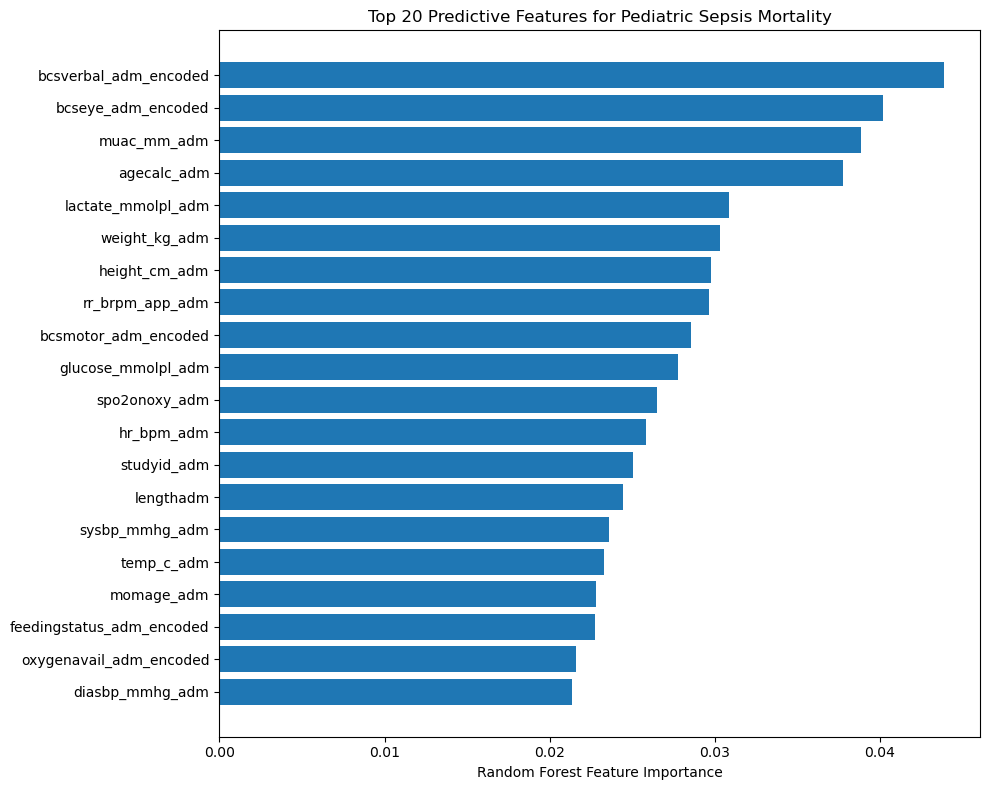

In [2440]:
# Sort features by importance
sorted_idx = np.argsort(importances)[-20:]  # Top 20 features
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("Top 20 Predictive Features for Pediatric Sepsis Mortality")
plt.tight_layout()
plt.show()

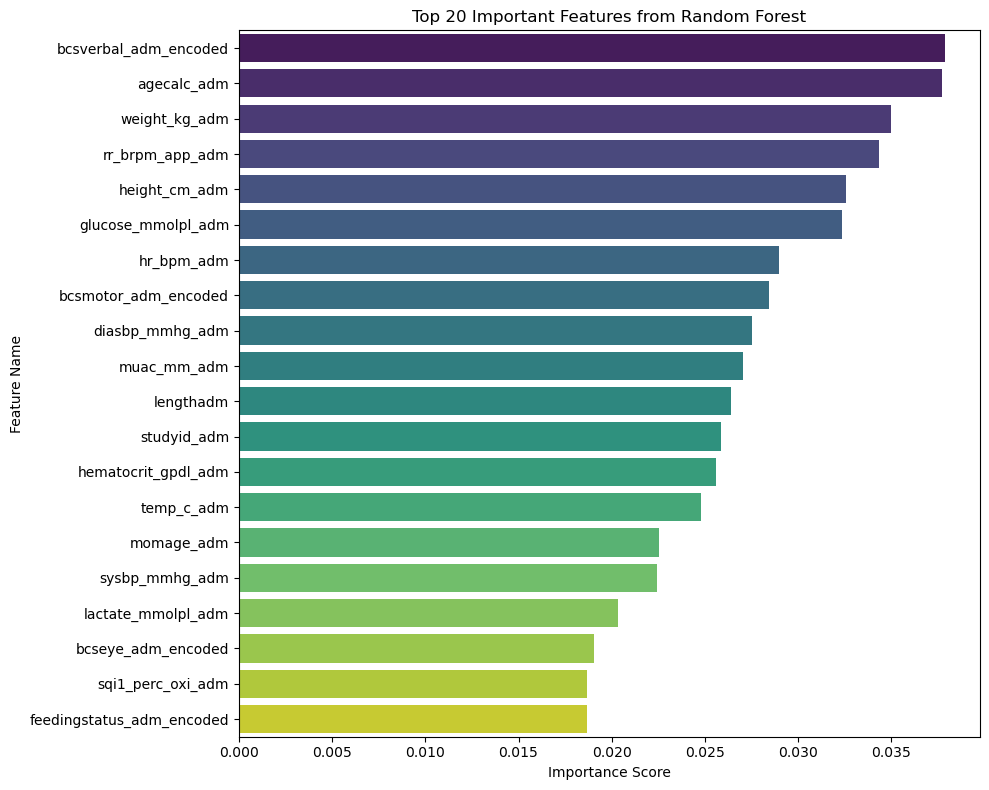

In [2441]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define features (X) and target (y)
X = sepsis_df.drop(columns='inhospital_mortality')  # Replace with actual target column
y = sepsis_df['inhospital_mortality']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize and fit RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 5: Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Important Features from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()


In [2442]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# 1. Separate features and target
X = sepsis_df.drop(columns=['inhospital_mortality'])  # Replace with your actual target column name
y = sepsis_df['inhospital_mortality']

# 2. Fit Random Forest with class_weight='balanced' to handle class imbalance
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X, y)

# 3. Create DataFrame of feature importances
importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# 4. Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 5. Display top 30 features
print("Top 30 Important Features:")
print(importance_df.head(20))

# Optional: select top N features for modeling
top_n = 50
top_features = importance_df['Feature'].head(top_n).tolist()
X_top = X[top_features]  # This is the reduced feature set for further modeling


Top 30 Important Features:
                      Feature  Importance
0          bcseye_adm_encoded    0.038896
1                 agecalc_adm    0.038002
2                 muac_mm_adm    0.037507
3       bcsverbal_adm_encoded    0.035677
4               weight_kg_adm    0.032803
5          glucose_mmolpl_adm    0.029578
6               height_cm_adm    0.029421
7             rr_brpm_app_adm    0.028812
8          lactate_mmolpl_adm    0.028410
9                  temp_c_adm    0.025654
10                 hr_bpm_adm    0.025453
11                 momage_adm    0.025065
12              spo2onoxy_adm    0.025014
13                  lengthadm    0.024728
14                studyid_adm    0.024473
15  feedingstatus_adm_encoded    0.023474
16            diasbp_mmhg_adm    0.023127
17       bcsmotor_adm_encoded    0.022721
18             sysbp_mmhg_adm    0.021865
19        hematocrit_gpdl_adm    0.021846


In [2443]:
# Step 1: Drop unwanted symptom columns from sepsis_df
# Drop columns that start with 'symptoms_adm_' or 'symptoms_dis_'
#sepsis_df = sepsis_df.drop(columns=[col for col in sepsis_df.columns if col.startswith('symptoms_adm_') or col.startswith('symptoms_dis_') or col.startswith('cookfuel_adm_') or col.startswith('comorbidity_adm_') or col.startswith('birthdetail_adm_')])

In [2444]:
print(sepsis_df.dtypes.sort_index())


agecalc_adm                      float64
alivechildren_adm                float64
badhealthduration_adm_encoded    float64
bcgscar_adm                        int32
bcseye_adm_encoded               float64
bcsmotor_adm_encoded             float64
bcsverbal_adm_encoded            float64
bednet_adm_encoded               float64
birthattend_adm_encoded          float64
birthdetail_adm___1                int32
birthdetail_adm___2                int32
birthdetail_adm___3                int32
birthdetail_adm___4                int32
birthdetail_adm___5                int32
birthdetail_adm___6                int32
caprefill_adm                      int32
caregiver_adm_new                  int32
caregiverage_adm_encoded         float64
caregivermarried_adm               int32
comorbidity_adm___1                int32
comorbidity_adm___10               int32
comorbidity_adm___11               int32
comorbidity_adm___12               int32
comorbidity_adm___2                int32
comorbidity_adm_

### Random Forest Predictive Model

Top 30 features by importance:
['muac_mm_adm', 'bcsverbal_adm_encoded', 'agecalc_adm', 'bcseye_adm_encoded', 'glucose_mmolpl_adm', 'rr_brpm_app_adm', 'height_cm_adm', 'lactate_mmolpl_adm', 'weight_kg_adm', 'spo2onoxy_adm', 'hr_bpm_adm', 'lengthadm', 'momage_adm', 'sysbp_mmhg_adm', 'hematocrit_gpdl_adm', 'bcsmotor_adm_encoded', 'temp_c_adm', 'diasbp_mmhg_adm', 'sqi2_perc_oxi_adm', 'feedingstatus_adm_encoded', 'momagefirstpreg_adm', 'oxygenavail_adm_encoded', 'spo2site2_pc_oxi_adm', 'sqi1_perc_oxi_adm', 'spo2site1_pc_oxi_adm', 'householdsize_adm', 'exclbreastfed_adm_encoded', 'bcgscar_adm', 'alivechildren_adm', 'lightfuel_adm']

Final Model Performance (after SMOTE):
AUC-ROC: 0.998
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       514
           1       0.98      0.98      0.98       513

    accuracy                           0.98      1027
   macro avg       0.98      0.98      0.98      1027
weighted avg       0.98      0.98      

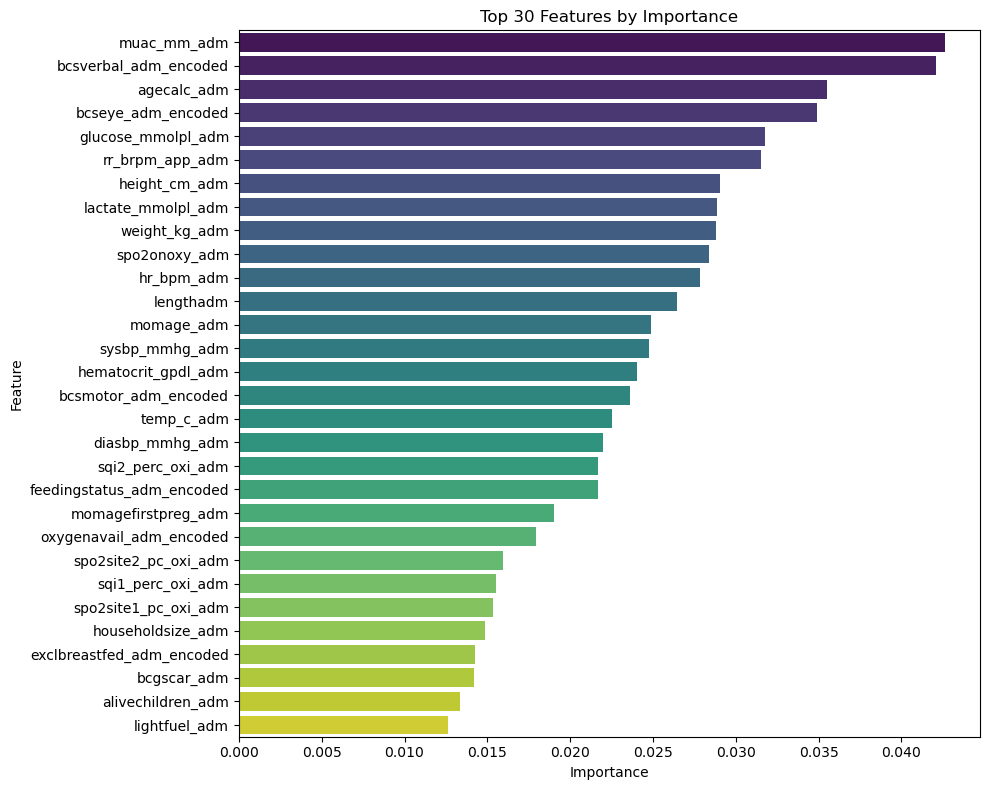

In [2555]:
#sepsis_df.drop('studyid_adm', axis=1, inplace=True)

# 1. Define features and target
X = sepsis_df.drop(columns=['inhospital_mortality'])
y = sepsis_df['inhospital_mortality']

# 2. Initial RF to rank features
rf_initial = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
rf_initial.fit(X, y)

# 3. Top 30 features
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_initial.feature_importances_
}).sort_values('Importance', ascending=False)

top_30_features = importance_df.head(30)['Feature'].tolist()
print("Top 30 features by importance:")
print(top_30_features)

X_top = X[top_30_features]

# 4. Apply SMOTE to handle class imbalance
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_top, y)

# 5. Train-test split (after resampling)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# 6. Train optimized RF
rf_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
rf_final.fit(X_train, y_train)

# 7. Evaluate
y_pred = rf_final.predict(X_test)
y_proba = rf_final.predict_proba(X_test)[:, 1]

print("\nFinal Model Performance (after SMOTE):")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")
print(classification_report(y_test, y_pred))

# 8. Visualize Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', 
            data=importance_df.head(30), 
            palette='viridis')
plt.title('Top 30 Features by Importance')
plt.tight_layout()
plt.show()


In [2557]:
print(f"Original samples: {len(y)}")
print(f"After SMOTE: {len(y_resampled)}")
print(f"Test set size: {len(y_test)}")

Original samples: 2686
After SMOTE: 5134
Test set size: 1027


In [2559]:
# Try without SMOTE first
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=42, stratify=y
)
rf_final.fit(X_train, y_train)
# Re-evaluate

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=200, random_state=42)

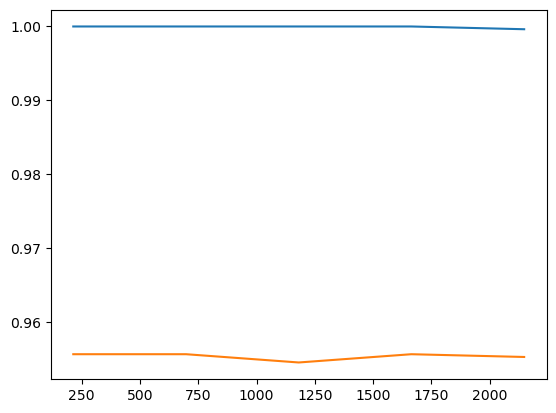

In [2561]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    rf_final, X_top, y, cv=5, n_jobs=-1
)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')

Top 30 features by importance:
['oxygenavail_adm_encoded', 'bcsverbal_adm_encoded', 'bcseye_adm_encoded', 'feedingstatus_adm_encoded', 'watersource_adm_encoded', 'exclbreastfed_adm_encoded', 'bcsmotor_adm_encoded', 'travelmethod_adm', 'symptoms_adm___14', 'deliveryloc_adm_encoded', 'bednet_adm_encoded', 'muac_mm_adm', 'alivechildren_adm', 'priorweekantimal_adm', 'malariastatuspos_adm', 'bcgscar_adm', 'cookfuel_adm___2', 'vaccpneumoc_adm_encoded', 'lactate_mmolpl_adm', 'deadchildren_adm', 'vaccdpt_adm_encoded', 'sex_adm', 'rr_brpm_app_adm', 'hr_bpm_adm', 'agecalc_adm', 'weight_kg_adm', 'priorhosp_adm_encoded', 'height_cm_adm', 'sqi2_perc_oxi_adm', 'hematocrit_gpdl_adm']

Final Model Performance (after SMOTE):
AUC-ROC: 0.730
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       514
           1       0.20      0.04      0.07        24

    accuracy                           0.95       538
   macro avg       0.58      0.52      0.52      

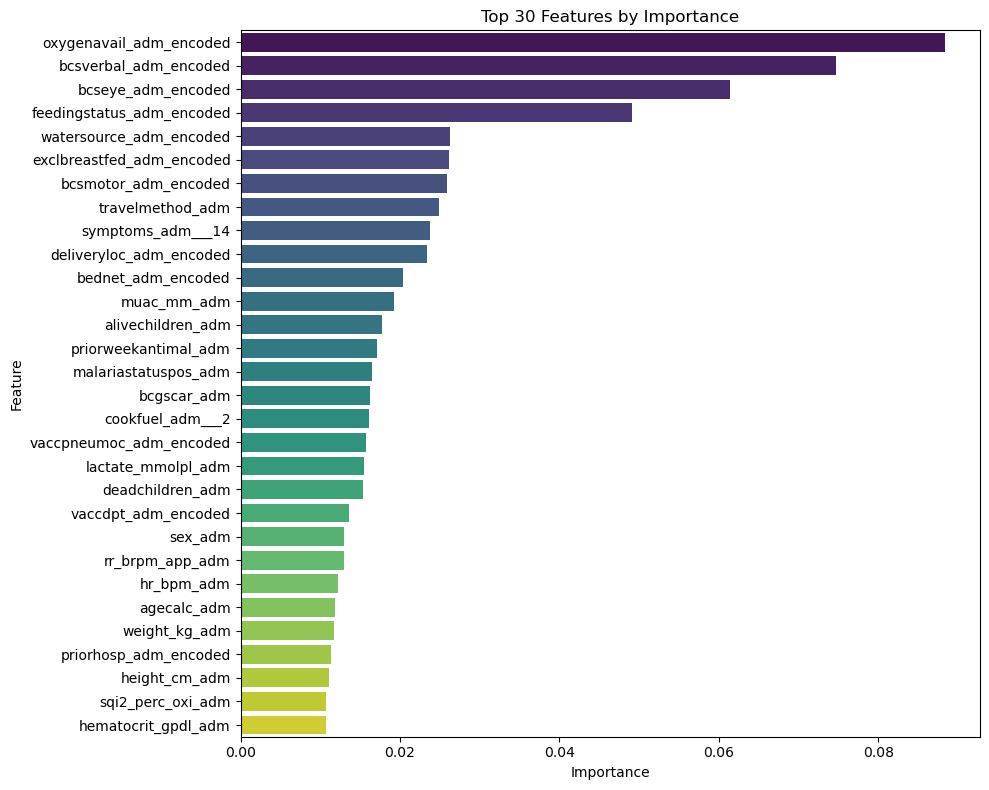

In [2545]:
# 1. Drop unnecessary columns if needed
#sepsis_df.drop('studyid_adm', axis=1, inplace=True)

# 2. Define features and target
X = sepsis_df.drop(columns=['inhospital_mortality'])
y = sepsis_df['inhospital_mortality']

# 3. Train-test split before applying SMOTE (ensure test set remains unseen)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Apply SMOTE only to the training set
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 5. Initial RF to rank features
rf_initial = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
rf_initial.fit(X_train_resampled, y_train_resampled)

# 6. Top 30 features by importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_initial.feature_importances_
}).sort_values('Importance', ascending=False)

top_30_features = importance_df.head(30)['Feature'].tolist()
print("Top 30 features by importance:")
print(top_30_features)

X_top = X[top_30_features]

# 7. Train optimized RF on resampled training data
rf_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
rf_final.fit(X_train_resampled, y_train_resampled)

# 8. Evaluate the final model on the test set
y_pred = rf_final.predict(X_test)
y_proba = rf_final.predict_proba(X_test)[:, 1]

print("\nFinal Model Performance (after SMOTE):")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")
print(classification_report(y_test, y_pred))

# 9. Performance on training set
y_train_pred = rf_final.predict(X_train_resampled)
y_train_proba = rf_final.predict_proba(X_train_resampled)[:, 1]

print("\nTraining Set Performance:")
print(f"AUC-ROC (Train): {roc_auc_score(y_train_resampled, y_train_proba):.3f}")
print(classification_report(y_train_resampled, y_train_pred))

# 10. Cross-validation to check for generalization (AUC-ROC score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc_scores = cross_val_score(rf_final, X_train_resampled, y_train_resampled, cv=cv, scoring='roc_auc')

print("\nCross-Validation AUC-ROC (5 folds):")
print(f"Mean AUC-ROC: {cv_auc_scores.mean():.3f}")
print(f"Standard Deviation: {cv_auc_scores.std():.3f}")

# 11. Visualize Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', 
            data=importance_df.head(30), 
            palette='viridis')
plt.title('Top 30 Features by Importance')
plt.tight_layout()
plt.show()


In [2446]:
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(rf_final, X_resampled, y_resampled, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC-ROC Scores: {cross_val_scores}")
print(f"Mean AUC-ROC: {cross_val_scores.mean():.3f}")


Cross-Validation AUC-ROC Scores: [0.86937296 0.99828961 0.99831615 0.99886606 0.96643222]
Mean AUC-ROC: 0.966


In [2447]:
# Initialize the StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Perform cross-validation and compute metrics for each fold
for train_index, test_index in cv.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # Train the model
    rf_final.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_final.predict(X_test)
    
    # Calculate metrics for the current fold
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Print the metrics for each fold
for fold, (acc, prec, rec, f1) in enumerate(zip(accuracies, precisions, recalls, f1_scores), 1):
    print(f"Fold {fold}:")
    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1-Score: {f1:.3f}")


Fold 1:
Accuracy: 0.969, Precision: 0.988, Recall: 0.949, F1-Score: 0.968
Fold 2:
Accuracy: 0.978, Precision: 0.988, Recall: 0.967, F1-Score: 0.977
Fold 3:
Accuracy: 0.963, Precision: 0.986, Recall: 0.940, F1-Score: 0.962
Fold 4:
Accuracy: 0.977, Precision: 0.986, Recall: 0.967, F1-Score: 0.976
Fold 5:
Accuracy: 0.980, Precision: 0.994, Recall: 0.965, F1-Score: 0.979


In [2533]:
# Evaluate on training set
y_train_pred = rf_final.predict(X_train)
y_train_proba = rf_final.predict_proba(X_train)[:, 1]

print("\nTraining Set Performance:")
print(f"AUC-ROC (Train): {roc_auc_score(y_train, y_train_proba):.3f}")
print(classification_report(y_train, y_train_pred))

# Evaluate on test set (already in your code)
print("\nFinal Model Performance (after SMOTE):")
print(f"AUC-ROC (Test): {roc_auc_score(y_test, y_proba):.3f}")
print(classification_report(y_test, y_pred))



Training Set Performance:
AUC-ROC (Train): 1.000
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2053
           1       1.00      0.99      0.99      2054

    accuracy                           0.99      4107
   macro avg       0.99      0.99      0.99      4107
weighted avg       0.99      0.99      0.99      4107


Final Model Performance (after SMOTE):
AUC-ROC (Test): 0.998
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       514
           1       0.98      0.98      0.98       513

    accuracy                           0.98      1027
   macro avg       0.98      0.98      0.98      1027
weighted avg       0.98      0.98      0.98      1027

